---
## Config

In [1]:
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("./utils_library/")
import configs.default_config as cfg
import configs.local_storage_config as storage_cfg
cfg.__dict__.update(storage_cfg.__dict__)

from training.utils import now
nowt=now()

from training import dataset_functions, callbacks, dataset_builder, load_weights, loss_metrics
import models.mobilenet_model as model
cfg.RUN_NAME="mobilenet_model_1" #for reference 

---
## Dataset

In [3]:
# Training settings
TRAINING_EPOCHS = 15
REAL_EPOCH_STEPS = int(cfg.DATASET_SIZE / cfg.BATCH_SIZE)
SHORT_EPOCH_STEPS= 50 #actual epocsh used in training, smaller than real epoch, but allows to track progress better, [in batches]
SHORT_TRAINING_EPOCHS=int(TRAINING_EPOCHS*(REAL_EPOCH_STEPS/SHORT_EPOCH_STEPS))
SHORT_VALIDATION_STEPS=5 #per short epoch

EPOCH_RATIO=int(REAL_EPOCH_STEPS / SHORT_EPOCH_STEPS)
# adam_learning_rate=0.001  #for reference
BASE_LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDUELE = np.zeros(100000)  #used with short epochs
LEARNING_RATE_SCHEDUELE[:8 * EPOCH_RATIO] = 1
LEARNING_RATE_SCHEDUELE[8 * EPOCH_RATIO:13 * EPOCH_RATIO] = 0.5
LEARNING_RATE_SCHEDUELE[13 * EPOCH_RATIO:15 * EPOCH_RATIO] = 0.1
LEARNING_RATE_SCHEDUELE *= BASE_LEARNING_RATE

In [6]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training
Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation
Found the following training TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training-001.tfrecords
./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training-002.tfrecords
Found the following validation TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 765

Dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


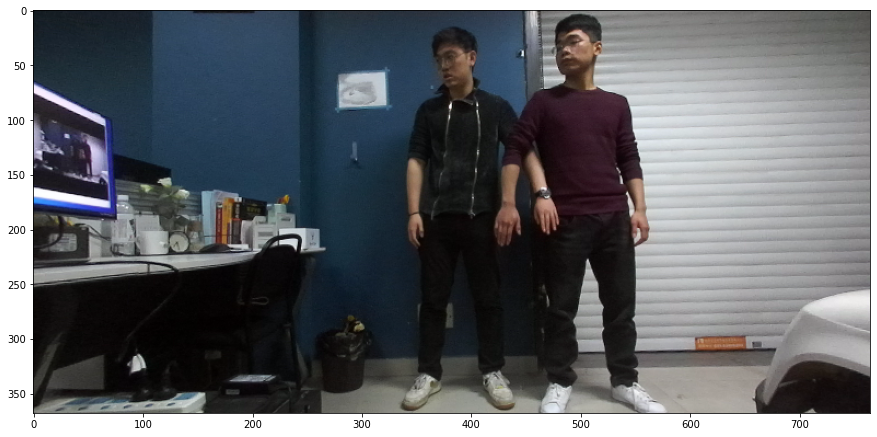

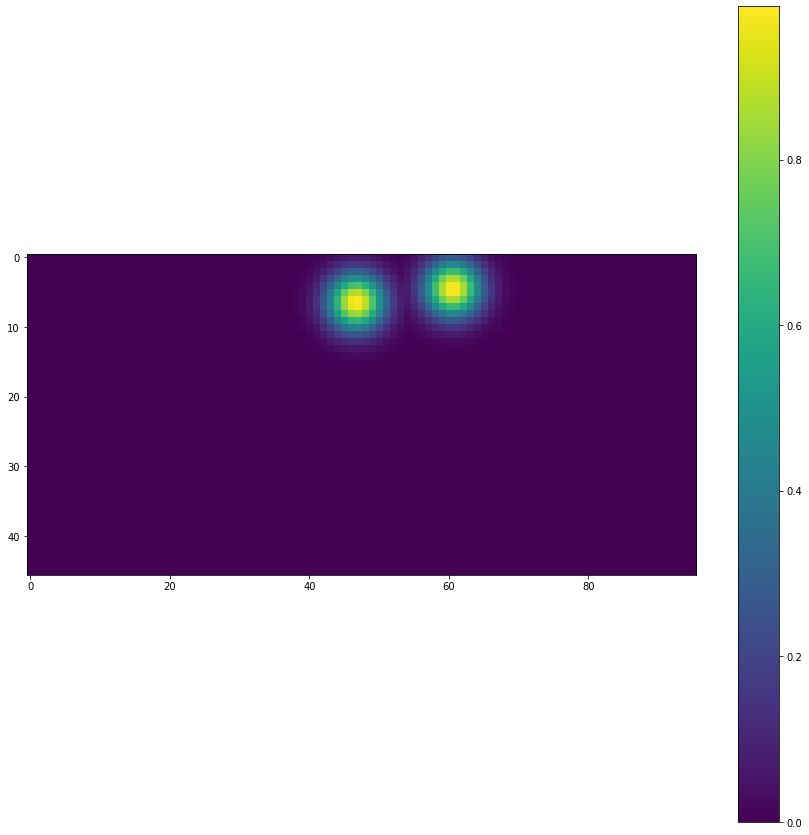

In [10]:
#Test element
print("Dataset shape:",dst) #this should match the model input, and output stages
dst_iter=iter(dst)
sample_elem=next(dst_iter)

#testing img
img = sample_elem[0][0][0,...]
plt.figure(figsize=[15,15])
plt.imshow(img)

#testing mask
m=sample_elem[1][4][0,...,0]
plt.figure(figsize=[15,15])
plt.imshow(m)
plt.colorbar()

---
## Model
### Load weights

In [6]:
if cfg.ASK_FOR_CHECKPOINTS:
    checkpoint,starting_epoch=load_weights.checkpoints_prompt(cfg)
else:
    checkpoint=None
    starting_epoch=0

Found no checkpoints


### Build Model

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import models.mobilenet_model as model

model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

def define():
    train_model,test_model=model_maker.create_models()   
    
    #this must match the model output order
    metrics=[
              [loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]    
             ,[loss_metrics.MeanAbsoluteRatio(),loss_metrics.AnalogRecall()]
        ]
    
    train_model.compile(
                    optimizer=tf.keras.optimizers.Adam(BASE_LEARNING_RATE)                   
                    ,loss=loss_metrics.MaskedMeanSquaredError()
                    ,loss_weights=[5,5,5,5,1,1]
                    ,metrics=metrics                           
                   )
    return train_model,test_model

train_model,test_model=define()
if (checkpoint):
    train_model.load_weights(checkpoint)

In [8]:
len(train_model.layers)

683

In [9]:
len(test_model.layers)

670

### Callbacks

In [8]:
all_callbacks=[
    callbacks.make_LRscheduler_callback(LEARNING_RATE_SCHEDUELE)
    ,callbacks.PrintLR()
    ,tf.keras.callbacks.TerminateOnNaN()
]

if cfg.SAVE_CHECKPOINTS:
    checkpoint_callback,checkpoint_path=callbacks.make_checkpoint_callback(cfg,nowt,REAL_EPOCH_STEPS*cfg.BATCH_SIZE)
    all_callbacks.append(checkpoint_callback)
if cfg.SAVE_TENSORBOARD:
    tensorboard_callback,tensorboard_path=callbacks.make_tensorboard_callback(cfg,nowt,EPOCH_RATIO)
    all_callbacks+=[tensorboard_callback]

In [9]:
#run to clean all tensorboard&checkpoints results
#!gsutil -m rm -r {cfg.TENSORBOARD_PATH}/*
#!gsutil -m rm -r {cfg.CHECKPOINTS_PATH}/*


---
## Training
Actually training

In [10]:
train_history=train_model.fit(
    dst
    ,epochs=SHORT_TRAINING_EPOCHS
    ,steps_per_epoch=SHORT_EPOCH_STEPS
    ,validation_steps=SHORT_VALIDATION_STEPS
    ,validation_data=dsv
    ,callbacks=all_callbacks
    ,initial_epoch=starting_epoch
)


Learning rate for epoch 0 is 0.0010000000474974513
Epoch 1/4200
12/50 [======>.......................] - ETA: 2:46 - loss: 19.2684 - s1pafs_output_loss: 1.0728 - s2pafs_output_loss: 1.0027 - s3pafs_output_loss: 1.0112 - s4pafs_output_loss: 0.6711 - s5kpts_output_loss: 0.2983 - s6kpts_output_loss: 0.1804 - s1pafs_output_MeanAbsoluteRatio: 22.5561 - s1pafs_output_analog_recall: 0.9547 - s2pafs_output_MeanAbsoluteRatio: 22.0568 - s2pafs_output_analog_recall: 0.9589 - s3pafs_output_MeanAbsoluteRatio: 21.6984 - s3pafs_output_analog_recall: 0.9586 - s4pafs_output_MeanAbsoluteRatio: 17.8504 - s4pafs_output_analog_recall: 0.9485 - s5kpts_output_MeanAbsoluteRatio: 8.7712 - s5kpts_output_analog_recall: 0.9780 - s6kpts_output_MeanAbsoluteRatio: 6.4600 - s6kpts_output_analog_recall: 0.9700

KeyboardInterrupt: 

In [ ]:
train_model.summary()

In [ ]:
#run to clear this run results
#!gsutil -m rm -r {tensorboard_path}/*
#!gsutil -m rm -r {checkpoint_path}/*

---
### Save results

In [ ]:
tmp_path='gs://dl_training_results/tmp/tensorflow/temp_weights'
train_model.save_weights(tmp_path)

local_model_maker=model.ModelMaker(cfg) #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

cpu_train_model,cpu_test_model=local_model_maker.create_models()

cpu_train_model.load_weights(tmp_path)
cpu_test_model.load_weights(tmp_path)

cpu_test_model.save(cfg.MODELS_PATH+"/test_"+cfg.RUN_NAME+nowt,include_optimizer=False) 
cpu_train_model.save(cfg.MODELS_PATH+"/train_"+cfg.RUN_NAME+nowt,include_optimizer=False) 